# Описание проекта

## Задача

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - 1) выделить целевые группы клиентов;
    - 2) предложить меры по снижению оттока;
    - 3) определить другие особенности взаимодействия с клиентами.

# Загрузим данные

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

- 'Churn' — факт оттока в текущем месяце;
- Текущие поля в датасете:
    - Данные пользователя за предыдущий до проверки факта оттока месяц:
         - 'gender' — пол
         - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
         - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
         - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
         - 'Phone' — наличие контактного телефона
         - 'Age' — возраст
         - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
         
 - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
      - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
      - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
      - 'Group_visits' — факт посещения групповых занятий
      - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
      - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
      - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Исследовательский анализ данных (EDA)

- Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe());

- Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());

- Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

- Постройте матрицу корреляций и отобразите её.

In [3]:
df.shape

(4000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
 df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby()

In [6]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [8]:
def f(a):
    fig = px.histogram(df, x=a, y='Churn', color="Churn",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
    fig.show()
b=df.columns.tolist()
interact(f, a=b)

interactive(children=(Dropdown(description='a', options=('gender', 'Near_Location', 'Partner', 'Promo_friends'…

<function __main__.f(a)>

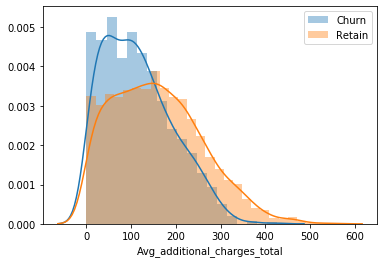

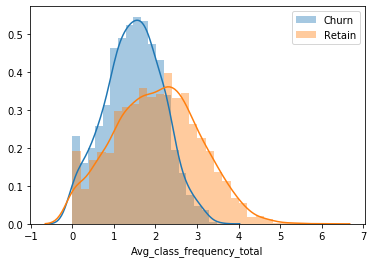

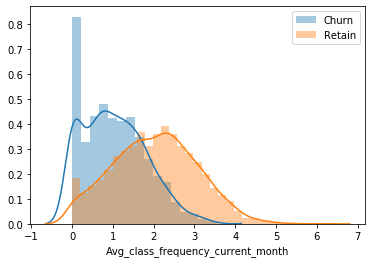

In [9]:
displot_col = ['Avg_additional_charges_total', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
left = df.loc[df['Churn']==1]
stayed = df.loc[df['Churn']==0]
for column in displot_col:
    sns.distplot(left[column])
    sns.distplot(stayed[column])
    plt.legend(['Churn', 'Retain'])
    plt.show();

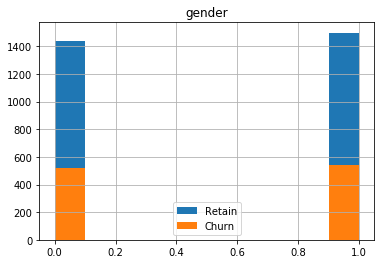

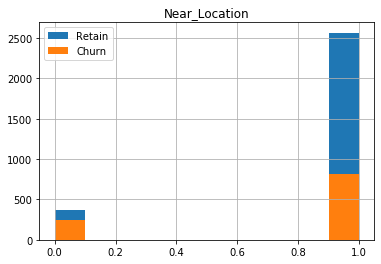

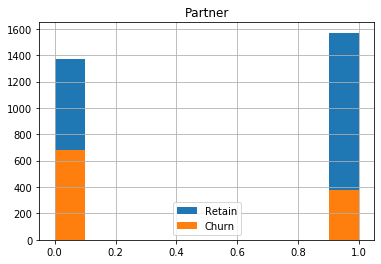

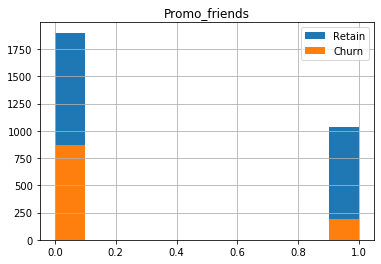

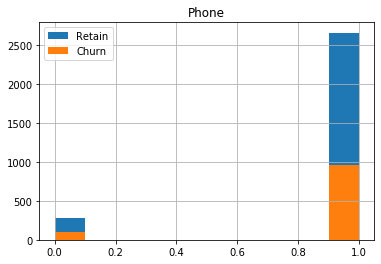

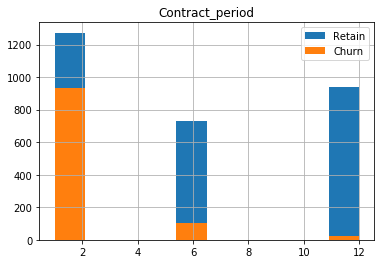

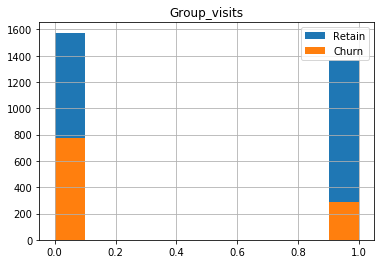

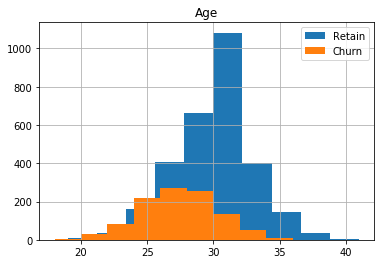

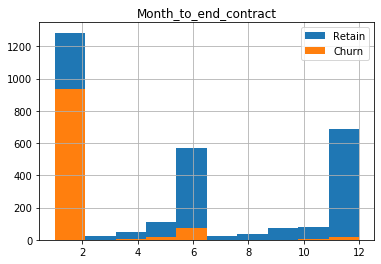

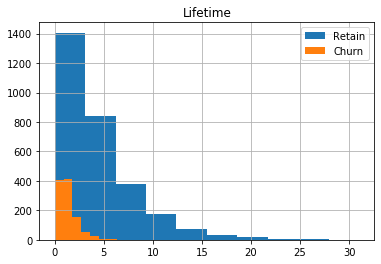

In [10]:
hist_col = ['gender',
 'Near_Location',
 'Partner',
 'Promo_friends',
 'Phone',
 'Contract_period',
 'Group_visits',
 'Age',
 'Month_to_end_contract',
 'Lifetime']

for column in hist_col:
    df.groupby('Churn')[column].hist()
    plt.legend(['Retain', 'Churn'])
    plt.title(column)
    plt.show()

- деление по полу примерно одинаково, поэтому пол не влияет на вероятность оттока,
- среди тех, кто прекратил посещать клуб, большинство живут поблизости, однако этот показатель ниже, чем в группе постоянных клиентов,
- большинство из тех, кто ушел, не являются сотрудниками компаний-партнеров (в группе тех, кто остался больше половины,),
- среди тех, кто остался, доля тех, кто пришел по промо, выше,
- подавляющее большинство предоставило свой контактный номер, эта цифра почти одинакова в обеих группах,
- в группе тех, кто остался, первоначальная продолжительность контракта в среднем выше,
- доля клиентов, посещавших групповые занятия, в два раза выше среди тех, кто остался,
- средний возраст ушедших клиентов ниже, чем у остальных,
- в среднем дополнительные расходы в фитнес-центрах немного выше среди тех, кто остался,
- среди тех, кто перестал посещать фитнес-центр, контракт закончился бы через 1-2 месяца. Тем, кто продолжал посещать спортзал, оставалось в среднем около 5 месяцев до конца контракта,
- в среднем клиенты уходят в течение первого месяца похода в спортзал,
- те, кто остался, посещают клуб чаще, чем те, кто ушел.

Построим матрицу корреляций и отобразите её

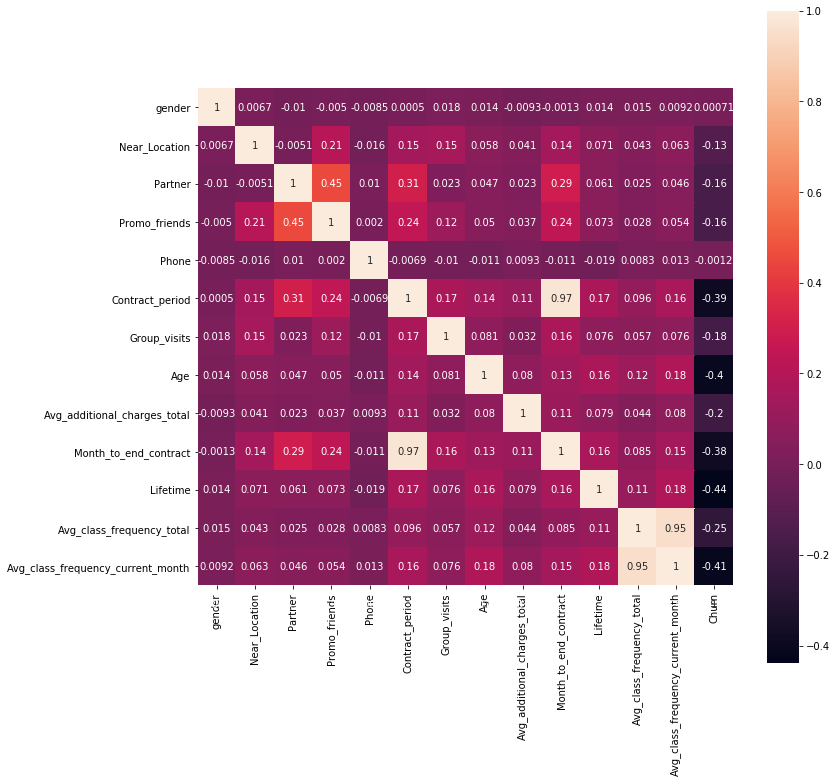

In [11]:
cm = df.corr() 

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm, annot = True, square=True)
ax.set_ylim(13, 0) 
plt.show()

Cильно коррелируют Month_to_end_contract и Contract_period (коэффициент корреляции Пирсона - 0.97), Avg_class_frequency_current_month и Avg_class_frequency_total (коэффициент корреляции Пирсона - 0.95).

Корреляция срока до окончания текущего действующего абонемента и длительности текущего действующего абонемента - понятна и логична, как и корреляция средней частоты посещения в неделю за предыдущий месяц и средней частоты посещения в неделю за все время.

### Построим модель прогнозирования оттока пользователей

Постройте модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:

- Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
- Обучите модель на train-выборке любыми двумя способами:
    - логистической регрессией
    - случайным лесом
- Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

Не забудьте указать параметр random_state при разделении выборки и задании алгоритма.

In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [16]:
forest_model = RandomForestClassifier(random_state = 0, n_estimators = 1000)
forest_model.fit(X_train_st, y_train)
forest_predictions = forest_model.predict(X_test_st)

print('forest_model:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, forest_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, forest_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, forest_predictions)))
print()
logistic_model = LogisticRegression(random_state=0, solver='lbfgs')
logistic_model.fit(X_train_st, y_train)
logistic_predictions = logistic_model.predict(X_test_st)
print('logistic_model:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_predictions)))

forest_model:
Accuracy: 0.92
Precision: 0.84
Recall: 0.82

logistic_model:
Accuracy: 0.92
Precision: 0.85
Recall: 0.83


Доля угаданных ответов и точность выше у случайного леса, полнота выше у логистической регрессии. Так как precision и recall направлены на избежание противоположных рисков, нужна сводная метрика, учитывающая баланс между метриками. Это F1-score:

In [17]:
print('f1_score для логистической регрессии: {:.3f}'.format(f1_score(y_test, logistic_predictions)))

f1_score для логистической регрессии: 0.841


In [18]:
print('f1_score для для случайного леса: {:.3f}'.format(f1_score(y_test, forest_predictions)))

f1_score для для случайного леса: 0.829


### Кластеризация пользователей

- Стандартизируйте данные.
- Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
- Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
- Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
- Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [19]:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

logistic_probabilities = logistic_model.predict_proba(X_test_st)[:,1]

In [20]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

linked = linkage(x_sc, method = 'ward')

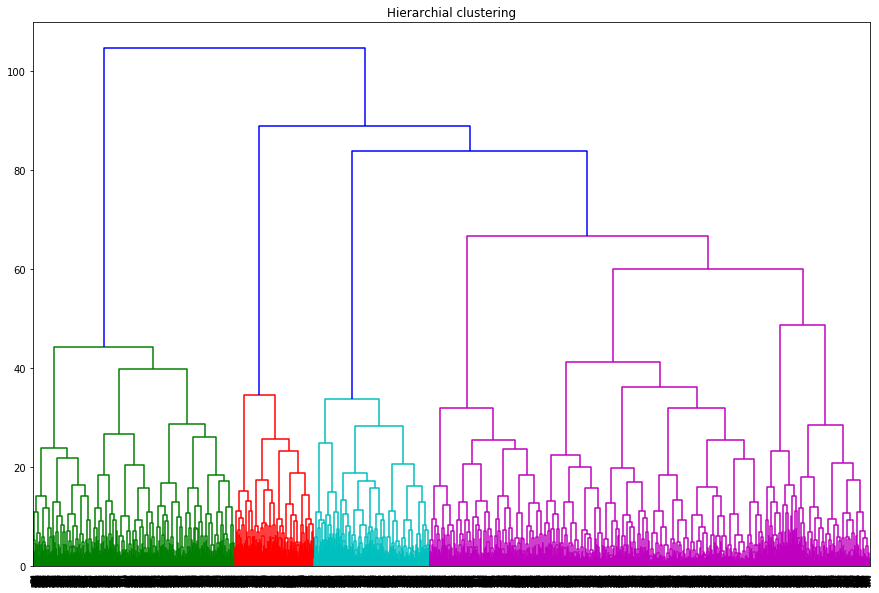

In [21]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()

Предложительное оптимальное число кластеров 4. Однако, так как клиент специально запросил 5, мы должны принять n_clusters = 5.

In [22]:
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

              gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km                                                               
0           0.522078       0.862338  0.470130       0.306494  0.000000   
1           0.480300       0.812383  0.000000       0.086304  1.000000   
2           0.560096       0.858173  0.337740       0.197115  0.998798   
3           0.509603       0.750320  1.000000       0.451985  1.000000   
4           0.495726       0.943376  0.752137       0.541667  1.000000   

            Contract_period  Group_visits        Age  \
cluster_km                                             
0                  4.787013      0.425974  29.301299   
1                  1.863039      0.324578  28.136961   
2                  2.734375      0.449519  30.204327   
3                  2.554417      0.303457  28.499360   
4                 11.352564      0.564103  29.993590   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km 

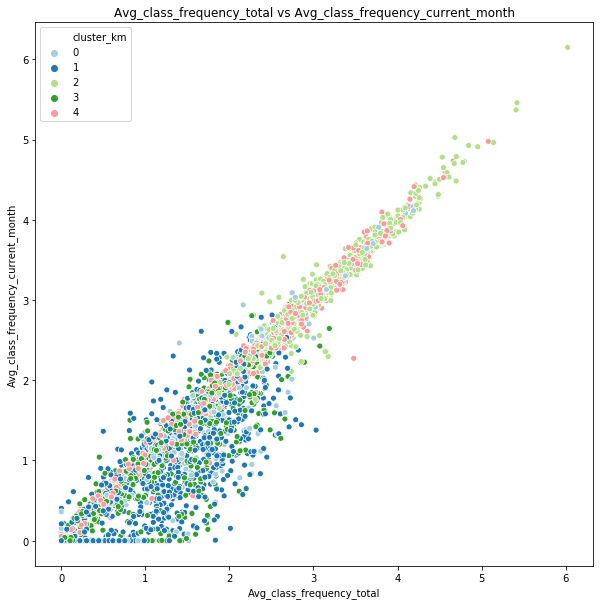

In [23]:
km = KMeans(n_clusters = 5,  random_state = 0)

labels = km.fit_predict(x_sc)
 
df['cluster_km'] = labels
 
print(df.groupby('cluster_km').mean())
 
show_clusters_on_plot(df, "Avg_class_frequency_total", "Avg_class_frequency_current_month","cluster_km")

In [24]:
@interact
def plot_hist_for_all_all_features(feature = df.columns):
   
    for churn_type in df['cluster_km'].unique():
        sns.distplot(df[df['cluster_km']==churn_type][feature],\
                     label='{} = {}'.format(churn_type, str(feature)), bins = 10)
        plt.Figure(figsize= (25,10))
        plt.title(feature)
        plt.legend()
        plt.show()

interactive(children=(Dropdown(description='feature', options=('gender', 'Near_Location', 'Partner', 'Promo_fr…

In [25]:
@interact
def plot_hist_for_all_all_features(feature = df.columns):
    
    for churn_type in df['cluster_km'].unique():
        sns.distplot(df[df['cluster_km']==churn_type][feature],\
                     label='{} = {}'.format(churn_type, str(feature)), bins = 10)
        plt.Figure(figsize= (10,10))
        plt.title(feature)
        plt.legend()
    plt.show()

interactive(children=(Dropdown(description='feature', options=('gender', 'Near_Location', 'Partner', 'Promo_fr…

In [26]:
clusters = df.groupby('cluster_km', as_index = False).agg('mean').sort_values(by = 'Churn').reset_index(drop = True)
clusters

,cluster_km,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129,0.023504
1,2,0.560096,0.858173,0.337740,0.197115,0.998798,2.734375,0.449519,30.204327,164.628354,2.522837,5.007212,2.926304,2.932554,0.048077
2,0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
3,3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172,0.395647
4,1,0.480300,0.812383,0.000000,0.086304,1.000000,1.863039,0.324578,28.136961,131.299377,1.787992,2.346154,1.325794,1.086387,0.550657


In [27]:
# churn rate by cluster
churn_by_cluster = df.groupby('cluster_km')['Churn'].mean().reset_index()
churn_by_cluster['Churn'] = churn_by_cluster['Churn'].map('{:,.0%}'.format)
churn_by_cluster

,cluster_km,Churn
0,0,27%
1,1,55%
2,2,5%
3,3,40%
4,4,2%


In [28]:
fig = go.Figure()
fig.add_trace(go.Pie(labels = df.groupby('cluster_km', as_index = False).agg({'gender' : 'count'})['cluster_km']
                      , values = df.groupby('cluster_km', as_index = False).agg({'gender' : 'count'})['gender'], 
                      hole=.3))
fig.update_traces(marker = dict(line = dict(color='#000000', width=1)))
fig.update_layout(title = {'text' : 'Диаграмма распределение клиентов по кластерам ', 'x' : 0.5, 'y' : 0.9})

In [29]:
df.groupby(['cluster_km','Churn']).mean()

gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km Churn                                                               
0          0      0.521277       0.886525  0.500000       0.361702  0.000000   
           1      0.524272       0.796117  0.388350       0.155340  0.000000   
1          0      0.450939       0.855950  0.000000       0.093946  1.000000   
           1      0.504259       0.776831  0.000000       0.080068  1.000000   
2          0      0.560606       0.862374  0.340909       0.204545  0.998737   
           1      0.550000       0.775000  0.275000       0.050000  1.000000   
3          0      0.508475       0.762712  1.000000       0.493644  1.000000   
           1      0.511327       0.731392  1.000000       0.388350  1.000000   
4          0      0.494530       0.944201  0.751641       0.543764  1.000000   
           1      0.545455       0.909091  0.772727       0.454545  1.000000   

                  Contract_period  Group_visits        Age  \
cluster_km Churn                                             
0          0             5.879433      0.460993  30.088652   
           1             1.796117      0.330097  27.145631   
1          0             2.446764      0.407098  29.586639   
           1             1.386712      0.257240  26.954003   
2          0             2.796717      0.453283  30.276515   
           1             1.500000      0.375000  28.775000   
3          0             3.105932      0.338983  29.618644   
           1             1.711974      0.249191  26.789644   
4          0            11.356674      0.568928  30.071116   
           1            11.181818      0.363636  26.772727   

                  Avg_additional_charges_total  Month_to_end_contract  \
cluster_km Churn                                                        
0          0                        156.755592               5.468085   
           1                        108.918677               1.757282   
1          0                        150.839113               2.323591   
           1                        115.354687               1.350937   
2          0                        165.959005               2.575758   
           1                        138.281459               1.475000   
3          0                        140.549478               2.853814   
           1                        113.411699               1.631068   
4          0                        165.684966              10.377462   
           1                        117.984422              10.318182   

                  Lifetime  Avg_class_frequency_total  \
cluster_km Churn                                        
0          0      5.010638                   1.958705   
           1      0.951456                   1.541987   
1          0      4.016701                   1.221025   
           1      0.982964                   1.411288   
2          0      5.199495                   2.938750   
           1      1.200000                   2.679866   
3          0      4.036017                   1.326641   
           1      0.993528                   1.399278   
4          0      4.910284                   2.035250   
           1      0.954545                   1.733975   

                  Avg_class_frequency_current_month  
cluster_km Churn                                     
0          0                               1.957864  
           1                               1.055188  
1          0                               1.224788  
           1                               0.973451  
2          0                               2.947595  
           1                               2.634758  
3          0                               1.322168  
           1                               0.953161  
4          0                               2.037850  
           1                               1.283899

In [30]:
fig = px.histogram(df, x='cluster_km', y='Churn', color="Churn",
                   hover_data=df.columns)
fig.show()

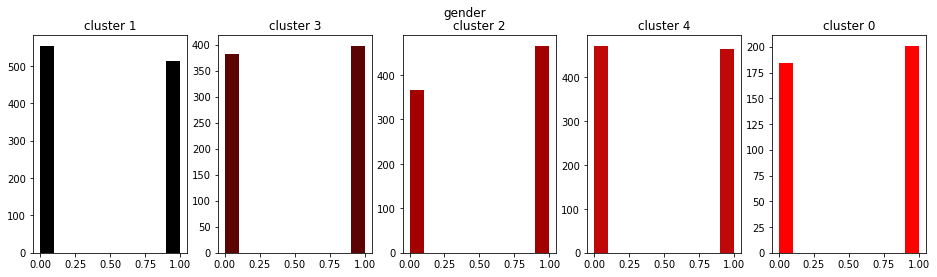

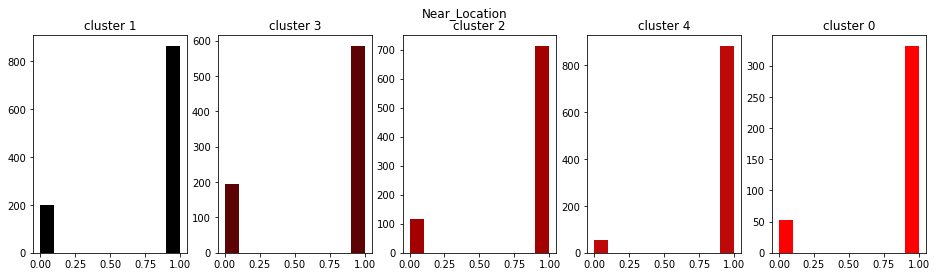

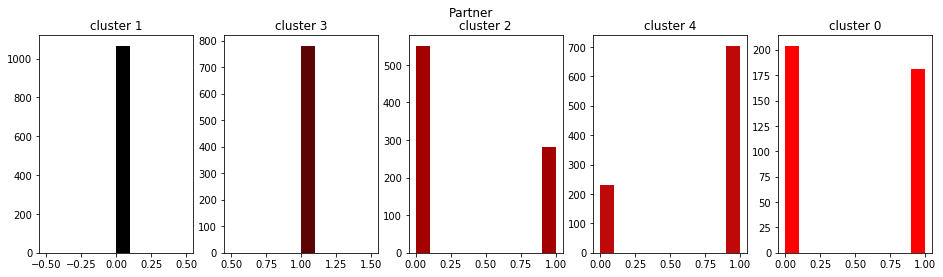

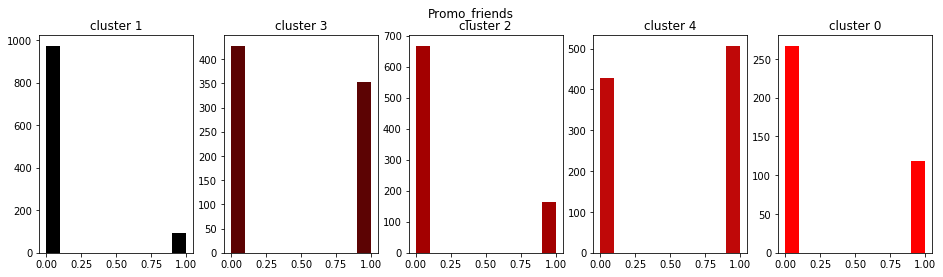

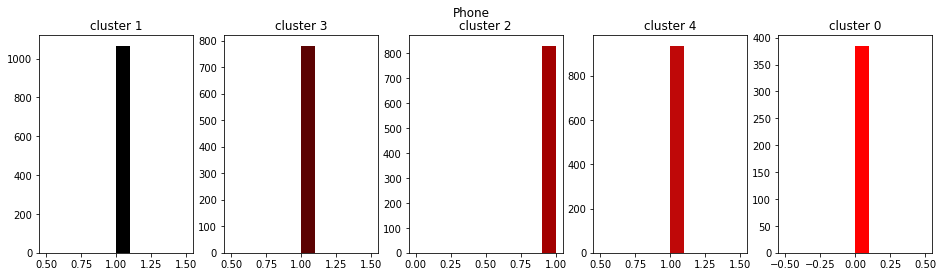

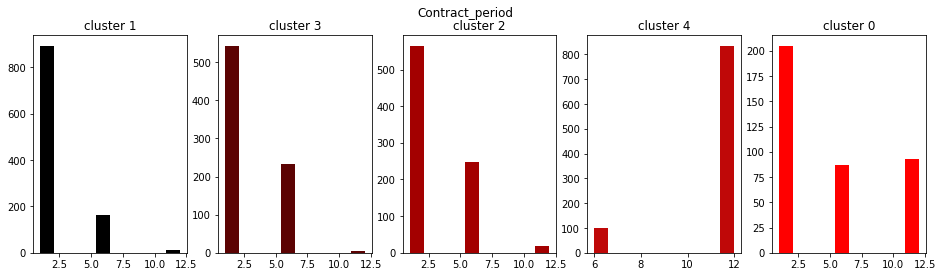

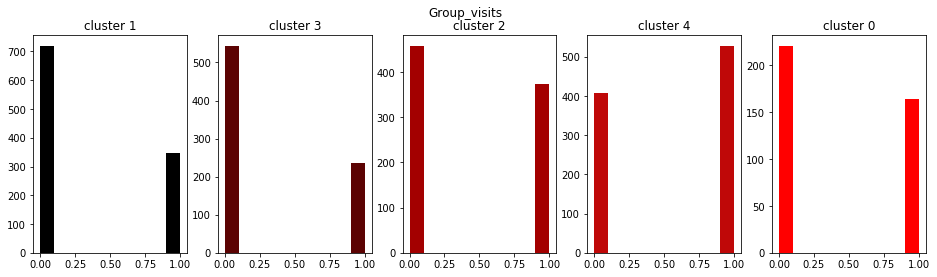

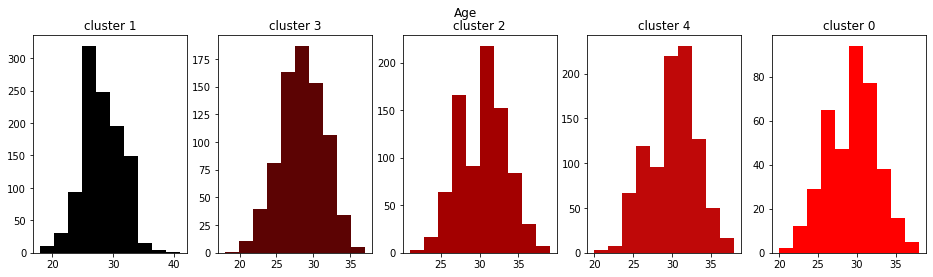

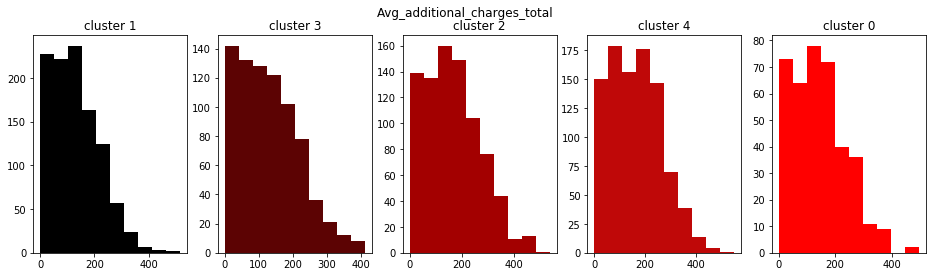

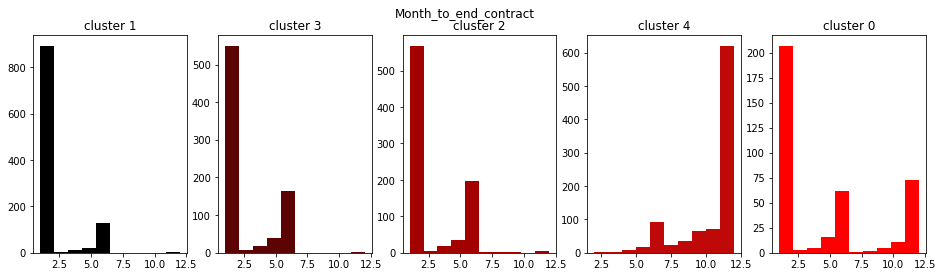

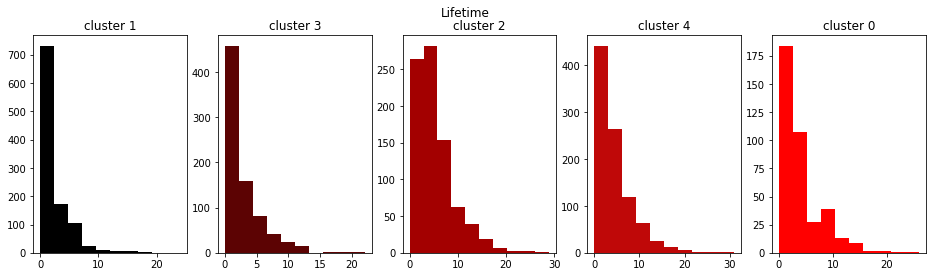

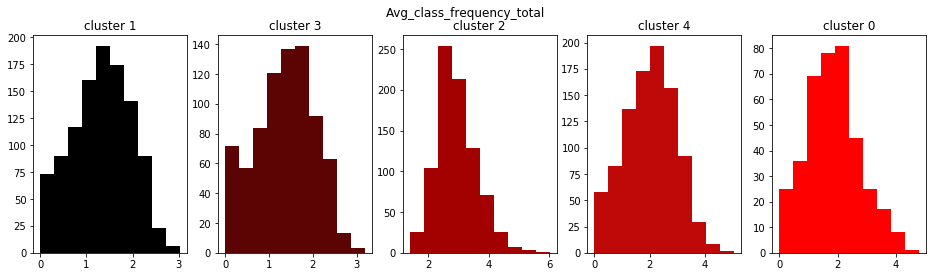

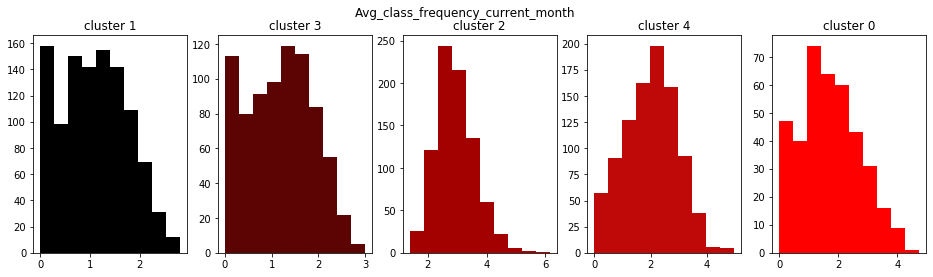

In [31]:
columns = df.loc[:, 'gender' : 'Avg_class_frequency_current_month'].columns
for column in columns:
    fig, (ax, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(16, 4))
    
    fig.suptitle(column)
    
    ax.set_title('cluster 1')
    ax1.set_title('cluster 3')
    ax2.set_title('cluster 2')
    ax3.set_title('cluster 4')
    ax4.set_title('cluster 0')

    ax.hist(df.query('cluster_km == 1')[column], color='#000000')
    ax1.hist(df.query('cluster_km == 3')[column], color='#5c0303')
    ax2.hist(df.query('cluster_km == 2')[column], color='#a30000')
    ax3.hist(df.query('cluster_km == 4')[column], color='#bf0808')
    ax4.hist(df.query('cluster_km == 0')[column], color='#ff0000')

### Выводы и рекомендации

Характеристики кластеров:

Кластер 0 – вероятность оттока 3% - средний срок контракта клиентов в этой группе значительно выше, и они посещают клуб в среднем около 5 месяцев (что выше, чем в большинстве других кластеров). Большинство из них являются сотрудниками компаний-партнеров клуба. Это постоянные клиенты с долгосрочными планами на спортзал и финансовыми бонусами от компаний-партнеров. Вероятность оттока минимальна.

Кластер 1 - вероятность оттока 27% - все клиенты, которые не указали свой номер телефона, сгруппированы здесь. Все остальные показатели этого кластера являются средними. Скорее всего, предоставление номера телефона не является существенным фактором для оттока абонентов.

Кластер 2 - вероятность оттока 44% - все клиенты, которые живут и работают далеко от спортзала, сгруппированы здесь. Почти никто из них не пришел через промо "Приведи друга". Несмотря на то, что эти клиенты посещают клуб довольно регулярно, вероятность их оттока довольно высока. Очевидно, что люди предпочитают ходить в фитнес-клуб, который находится рядом с их домом или офисом, и вместе с друзьями.

Кластер 3 - вероятность оттока 51% - включает клиентов, подписавших краткосрочный контракт с клубом. Кроме того, многие из них посещали клуб редко или вообще не посещали его за последний месяц. Эти люди присоединились к клубу, чтобы попробовать, но не стали постоянными посетителями. Вероятность оттока среди них высока.

Кластер 4 - вероятность оттока 7% - это клиенты, которые посещают клуб чаще других групп (в среднем 2-3 раза в неделю). Это постоянные посетители клуба, вероятность их потерять невелика.

Кластеры №№ 0, 1, 4 – самые лояльные клиенты, посещение зала для них – сформированная привычка. Данные кластеры активно используют платные услуги фитнес-центра, именно на это следует уделить внимание при составлении персонализированных предложений, нацеленных на повышение выручки фитнес-центра. За 1-2 месяца до окончания текущего абонемента, стоит предлагать пользователям новый абонемент на "выгодных" условиях.

Отсутствуют номера телефонов практически 10% клиентов, с данным кластером нет возможности выстраивать удаленную связь, присылать персональные предложения и актуальные новости фитнес-центра. Необходимо сконцентрировать внимание отдела продаж на этой проблеме, сделать данное поле обязательным при заполнении новых анкет и постараться собрать номера телефонов текущих клиентов.

Таким образом, клиенты с характеристиками, аналогичными характеристикам кластеров 2 и 3, с большей вероятностью прекратят посещение клуба. Мы можем создать специальные акции для таких клиентов, а также более выгодные условия для тех, кто сразу подписывает более длинные договоры о членстве (например, ограниченная по времени акция с более низкой ценой для 12-месячного членства).
Также было бы хорошо сосредоточиться на привлечении клиентов, которые живут и работают в районе, расположенном рядом с клубом. Например, чтобы настроить геотаргетинг онлайн-рекламы в этой области.